# **Single-Machine Scheduling Problem**

---
This notebook solves single-machine scheduling problem as the primary problem in the context of schediling problems. The task is to schedule a set of jobs on a single machine given the release time, duration, and due time for each job. Date for the example problem is from Christelle Gueret, Christian Prins, Marc Sevaux, "Applications of Optimization with Xpress-MP," Chapter 5, Dash Optimization, 2000.


In [ ]:
pip install ortools

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import numpy as np
from google.colab import files
import io

## **Data**



In [ ]:
JOBS = {
    'A': {'release': 0, 'duration': 5, 'due': 0, 'weight': 2},
    'B': {'release': 0, 'duration': 6, 'due': 0, 'weight': 1},
    'C': {'release': 0, 'duration': 8, 'due': 0, 'weight': 4},
    'D': {'release': 0, 'duration': 4, 'due': 0, 'weight': 8},
    'E': {'release': 0, 'duration': 2, 'due':  0, 'weight': 1},
    'F': {'release': 0, 'duration': 3, 'due': 0, 'weight': 2},
    'G': {'release': 0, 'duration': 2, 'due': 0, 'weight': 1},
}
JOBS

{'A': {'release': 0, 'duration': 5, 'due': 0, 'weight': 2},
 'B': {'release': 0, 'duration': 6, 'due': 0, 'weight': 1},
 'C': {'release': 0, 'duration': 8, 'due': 0, 'weight': 4},
 'D': {'release': 0, 'duration': 4, 'due': 0, 'weight': 8},
 'E': {'release': 0, 'duration': 2, 'due': 0, 'weight': 1},
 'F': {'release': 0, 'duration': 3, 'due': 0, 'weight': 2},
 'G': {'release': 0, 'duration': 2, 'due': 0, 'weight': 1}}

## **Gantt Chart**



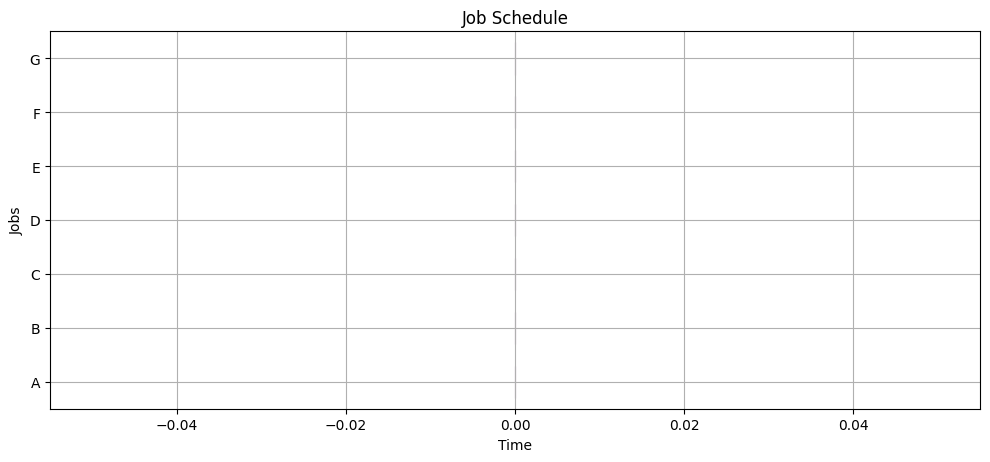

In [ ]:
def gantt(JOBS, SCHEDULE={}):
    bw = 0.3
    plt.figure(figsize=(12, 0.7*(len(JOBS.keys()))))
    idx = 0
    for j in sorted(JOBS.keys()):
        x = JOBS[j]['release']
        y = JOBS[j]['due']
        light_lilac_rgb = (200/255, 162/255, 200/255)
        plt.fill_between([x,y], [idx-bw, idx-bw], [idx+bw, idx+bw], color=light_lilac_rgb, alpha=0.5)

        if j in SCHEDULE.keys():
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='hotpink', alpha=0.7)
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            plt.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        idx += 1

    plt.ylim(-0.5, idx-0.5)
    plt.title('Job Schedule')
    plt.xlabel('Time')
    plt.ylabel('Jobs')
    plt.yticks(range(len(JOBS)), JOBS.keys())
    plt.grid()
    xlim = plt.xlim()

    if SCHEDULE:
        for j in SCHEDULE.keys():
            if 'machine' not in SCHEDULE[j].keys():
                SCHEDULE[j]['machine'] = 1
        MACHINES = sorted(set([SCHEDULE[j]['machine'] for j in SCHEDULE.keys()]))

        plt.figure(figsize=(12, 0.7*len(MACHINES)))
        for j in sorted(SCHEDULE.keys()):
            idx = MACHINES.index(SCHEDULE[j]['machine'])
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='hotpink', alpha=0.7)
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            # plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='white', alpha=0.5)
            # plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='w')
            plt.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        plt.xlim(xlim)
        plt.ylim(-0.5, len(MACHINES)-0.5)
        plt.title('Machine Schedule')
        plt.yticks(range(len(MACHINES)), MACHINES)
        plt.ylabel('Machines')
        plt.grid()

gantt(JOBS)

## **Dispatching Rules**

---

The data consists of a Python dictionary of jobs. Each job is labeled by a key, and an associated data dictionary provides the time at which the job is released to the for machine processing, the expected duration of the job, and the due date.

In [ ]:
def schedule(JOBS, order=sorted(JOBS.keys())):
    "Schedule a dictionary of JOBS on a single machine in a specified order."
    start = 0
    finish = 0
    SCHEDULE = {}

    for job in order:
        start = max(JOBS[job]['release'], finish)
        finish = start + JOBS[job]['duration']
        SCHEDULE[job] = {'start': start, 'finish': finish}
    return SCHEDULE

SCHEDULE = schedule(JOBS)
SCHEDULE

{'A': {'start': 0, 'finish': 5},
 'B': {'start': 5, 'finish': 11},
 'C': {'start': 11, 'finish': 19},
 'D': {'start': 19, 'finish': 23},
 'E': {'start': 23, 'finish': 25},
 'F': {'start': 25, 'finish': 28},
 'G': {'start': 28, 'finish': 30}}

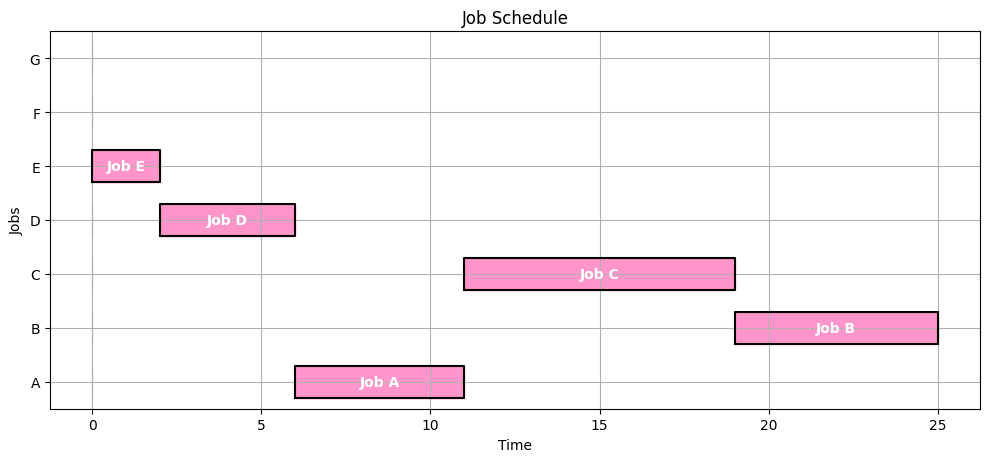

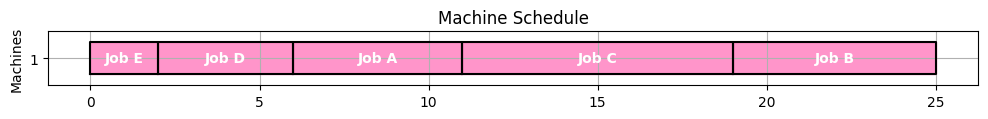

In [ ]:
gantt(JOBS, schedule(JOBS, ['E', 'D', 'A', 'C', 'B']))

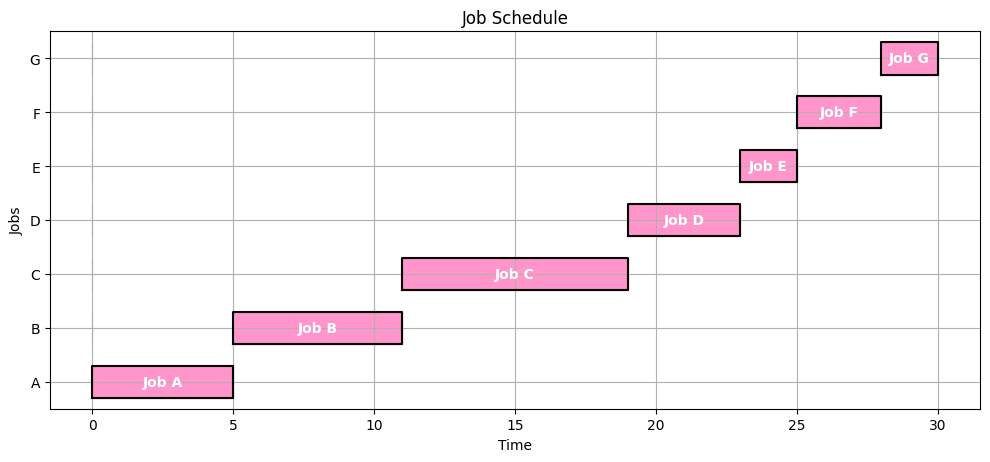

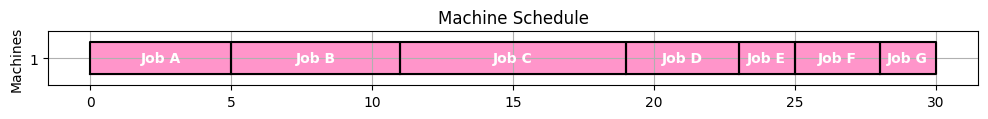

In [ ]:
gantt(JOBS, SCHEDULE)

## **Key Performance Indicators (KPI)**



In [ ]:
def kpi(JOBS, SCHEDULE):
    KPI = {}
    KPI['Makespan'] = max(SCHEDULE[job]['finish'] for job in SCHEDULE)
    KPI['Max Pastdue'] = max(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Sum of Pastdue'] = sum(max(0, SCHEDULE[job]['finish'] - JOBS[job]['due']) for job in SCHEDULE)
    KPI['Number Pastdue'] = sum(SCHEDULE[job]['finish'] > JOBS[job]['due'] for job in SCHEDULE)
    KPI['Number on Time'] = sum(SCHEDULE[job]['finish'] <= JOBS[job]['due'] for job in SCHEDULE)
    KPI['Fraction on Time'] = KPI['Number on Time']/len(SCHEDULE)
    KPI['Average Flow Time'] = sum(SCHEDULE[job]['finish']/len(SCHEDULE) for job in SCHEDULE)
    KPI['Weighted Flow Time'] = sum(SCHEDULE[job]['finish'] * JOBS[job]['weight'] for job in SCHEDULE)
    return KPI

kpi(JOBS, SCHEDULE)

{'Makespan': 30,
 'Max Pastdue': 30,
 'Sum of Pastdue': 141,
 'Number Pastdue': 7,
 'Number on Time': 0,
 'Fraction on Time': 0.0,
 'Average Flow Time': 20.142857142857142,
 'Weighted Flow Time': 392}

### **FCFS**

In [ ]:
mylist = [[1,2,3],[2,3,4],[5,8,7],[4,3]]
sorted(mylist, key=lambda x: x[1])

[[1, 2, 3], [2, 3, 4], [4, 3], [5, 8, 7]]

In [ ]:
def element_1(x):
    return x[1]

sorted(mylist, key=element_1)

[[1, 2, 3], [2, 3, 4], [4, 3], [5, 8, 7]]

['A', 'B', 'C', 'D', 'E', 'F', 'G']


{'Makespan': 30,
 'Max Pastdue': 30,
 'Sum of Pastdue': 141,
 'Number Pastdue': 7,
 'Number on Time': 0,
 'Fraction on Time': 0.0,
 'Average Flow Time': 20.142857142857142,
 'Weighted Flow Time': 392}

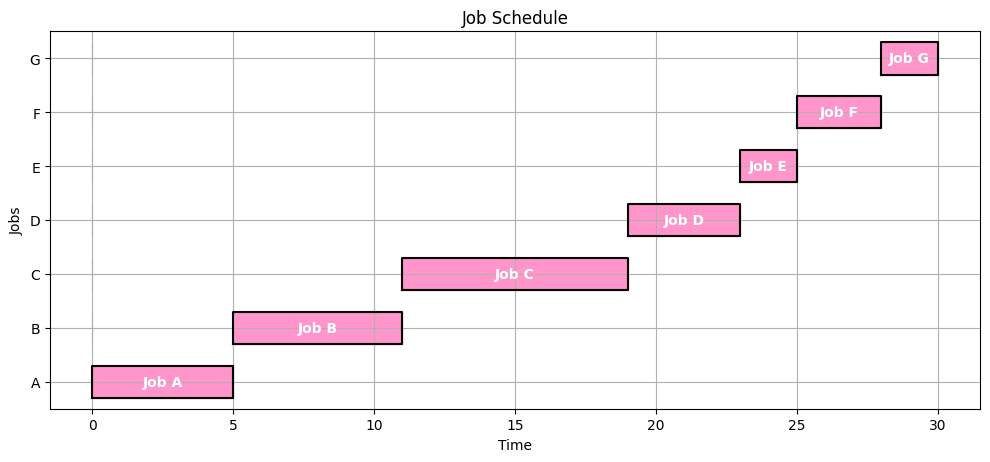

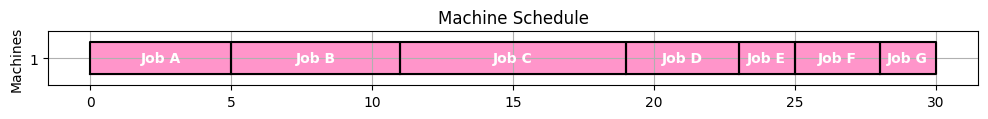

In [ ]:
order=sorted(JOBS, key=lambda x: (JOBS[x]['release'], x))
print(order)
gantt(JOBS, schedule(JOBS,order))
kpi(JOBS, schedule(JOBS,order))

### **SPT**

['E', 'G', 'F', 'D', 'A', 'B', 'C']


{'Makespan': 30,
 'Max Pastdue': 30,
 'Sum of Pastdue': 92,
 'Number Pastdue': 7,
 'Number on Time': 0,
 'Fraction on Time': 0.0,
 'Average Flow Time': 13.142857142857142,
 'Weighted Flow Time': 282}

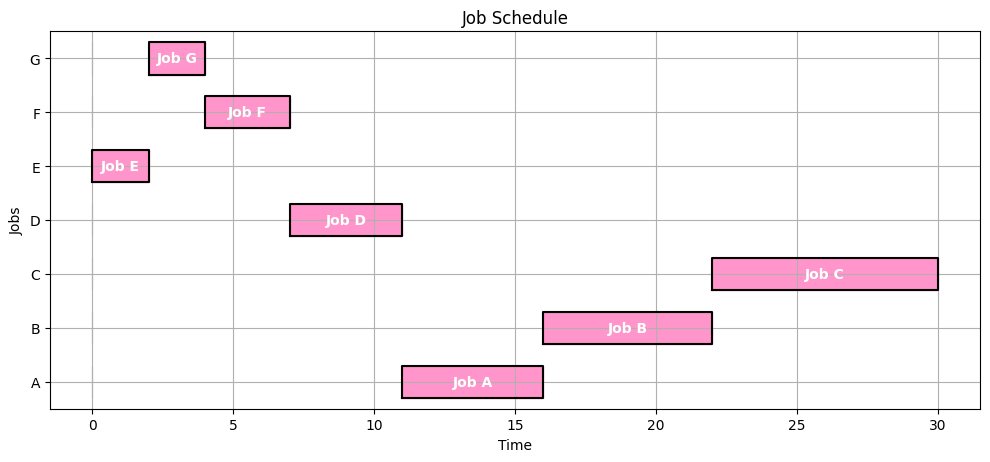

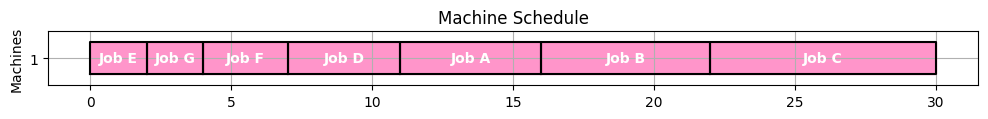

In [ ]:
# Create a sorted list of job keys based on the duration of each job
order = sorted(JOBS.keys(), key=lambda job: JOBS[job]['duration'])
print(order)
gantt(JOBS, schedule(JOBS,order))
kpi(JOBS, schedule(JOBS,order))

### **LPT**

['C', 'B', 'A', 'D', 'F', 'E', 'G']


{'Makespan': 30,
 'Max Pastdue': 30,
 'Sum of Pastdue': 148,
 'Number Pastdue': 7,
 'Number on Time': 0,
 'Fraction on Time': 0.0,
 'Average Flow Time': 21.142857142857142,
 'Weighted Flow Time': 378}

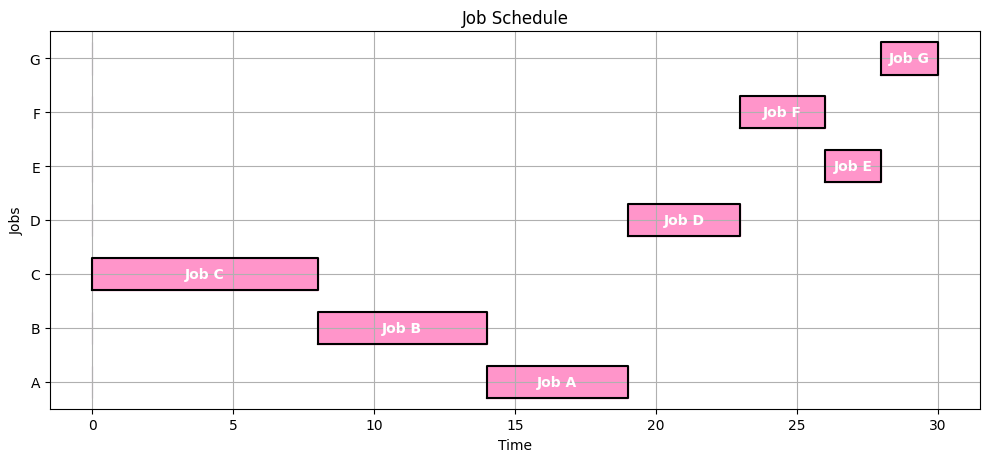

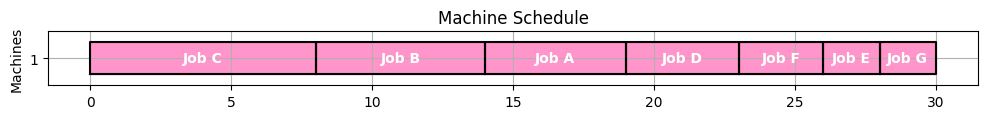

In [ ]:
order = sorted(JOBS.keys(), key=lambda job: JOBS[job]['duration'], reverse = True)
print(order)
gantt(JOBS, schedule(JOBS,order))
kpi(JOBS, schedule(JOBS,order))

### **WSPT**

['D', 'F', 'E', 'G', 'C', 'A', 'B']
[0.4, 0.16666666666666666, 0.5, 2.0, 0.5, 0.6666666666666666, 0.5]


{'Makespan': 30,
 'Max Pastdue': 30,
 'Sum of Pastdue': 104,
 'Number Pastdue': 7,
 'Number on Time': 0,
 'Fraction on Time': 0.0,
 'Average Flow Time': 14.857142857142858,
 'Weighted Flow Time': 220}

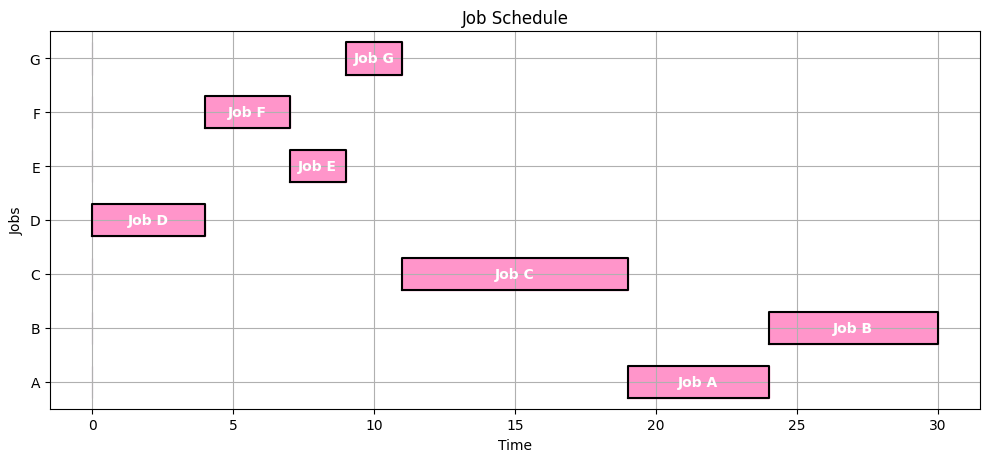

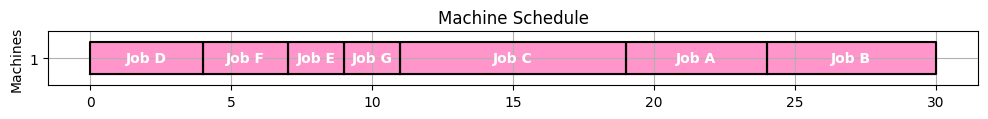

In [ ]:
order = sorted(JOBS.keys(), key=lambda x: (-JOBS[x]['weight'] / JOBS[x]['duration'], JOBS[x]['duration']))
print(order)
print([JOBS[x]['weight']/JOBS[x]['duration'] for x in JOBS])
gantt(JOBS, schedule(JOBS,order))
kpi(JOBS, schedule(JOBS,order))

In [ ]:
def schedule_wspt(JOBS):
    # Print original ratios for debugging
    print("Original Ratios: ")
    for job in JOBS:
        ratio = JOBS[job]['weight'] / JOBS[job]['duration']
        print(f"Job {job}: Ratio = {ratio}")

    # Create a sorted list of job keys based on the weight/duration ratio in ascending order
    order = sorted(JOBS.keys(), key=lambda x: JOBS[x]['weight'] / JOBS[x]['duration'])

    # Print sorted order for debugging
    print("Sorted Order: ")
    for job in order:
        ratio = JOBS[job]['weight'] / JOBS[job]['duration']
        print(f"Job {job}: Ratio = {ratio}")

    return schedule(JOBS, order=order)

# Example JOBS dictionary with specific weights and durations to match your example ratios
JOBS = {
    'JobA': {'release': 0, 'duration': 10, 'weight': 4},  # Ratio = 0.4
    'JobB': {'release': 3, 'duration': 6, 'weight': 1},  # Ratio = 0.166...
    'JobC': {'release': 5, 'duration': 2, 'weight': 1},  # Ratio = 0.5
    'JobD': {'release': 2, 'duration': 1, 'weight': 2},  # Ratio = 2.0
    'JobE': {'release': 4, 'duration': 2, 'weight': 1},  # Ratio = 0.5
    'JobF': {'release': 1, 'duration': 3, 'weight': 2},  # Ratio = 0.666...
    'JobG': {'release': 2, 'duration': 2, 'weight': 1}   # Ratio = 0.5
}

# Schedule the jobs using the WSPT policy
SCHEDULE = schedule_wspt(JOBS)
print(SCHEDULE)


Original Ratios: 
Job JobA: Ratio = 0.4
Job JobB: Ratio = 0.16666666666666666
Job JobC: Ratio = 0.5
Job JobD: Ratio = 2.0
Job JobE: Ratio = 0.5
Job JobF: Ratio = 0.6666666666666666
Job JobG: Ratio = 0.5
Sorted Order: 
Job JobB: Ratio = 0.16666666666666666
Job JobA: Ratio = 0.4
Job JobC: Ratio = 0.5
Job JobE: Ratio = 0.5
Job JobG: Ratio = 0.5
Job JobF: Ratio = 0.6666666666666666
Job JobD: Ratio = 2.0
{'JobB': {'start': 3, 'finish': 9}, 'JobA': {'start': 9, 'finish': 19}, 'JobC': {'start': 19, 'finish': 21}, 'JobE': {'start': 21, 'finish': 23}, 'JobG': {'start': 23, 'finish': 25}, 'JobF': {'start': 25, 'finish': 28}, 'JobD': {'start': 28, 'finish': 29}}


## **Modeling**

---


### **Parameters**


Symbol       | Description                                    
--- | :---:                    
$d_j$      | Due time for task                              
$p_j$ | Duration of task                               
$r_j$  | Time task $j$ becomes available for processing

### **Decision variables**

Symbol |	Description
--- | :---:
$C_j$ | Start of task $j$
$y_{i,j}$ | auxilary variable, equal to one if task $i$ is going to be processed after task $j$
$U_j$ | Equal to one if task  $j$ has past its due
$C_{max}$ | Time to complete all jobs
$L_{max}$ | Time to complete all jobs


### **Model**


### **MILP**

In [ ]:
from ortools.linear_solver import pywraplp

### **Data**

In [ ]:
JOBS_2 = {
    'A': {'release': 2, 'duration': 5, 'due': 10, 'weight': 2},
    'B': {'release': 5, 'duration': 6, 'due': 21, 'weight': 1},
    'C': {'release': 4, 'duration': 8, 'due': 15, 'weight': 4},
    'D': {'release': 0, 'duration': 4, 'due': 10, 'weight': 8},
    'E': {'release': 0, 'duration': 2, 'due':  5, 'weight': 1},
    'F': {'release': 8, 'duration': 3, 'due': 15, 'weight': 2},
    'G': {'release': 9, 'duration': 2, 'due': 22, 'weight': 1},
}
JOBS_2

{'A': {'release': 2, 'duration': 5, 'due': 10, 'weight': 2},
 'B': {'release': 5, 'duration': 6, 'due': 21, 'weight': 1},
 'C': {'release': 4, 'duration': 8, 'due': 15, 'weight': 4},
 'D': {'release': 0, 'duration': 4, 'due': 10, 'weight': 8},
 'E': {'release': 0, 'duration': 2, 'due': 5, 'weight': 1},
 'F': {'release': 8, 'duration': 3, 'due': 15, 'weight': 2},
 'G': {'release': 9, 'duration': 2, 'due': 22, 'weight': 1}}

#### WSPT

{'Makespan': 30.0,
 'Max Pastdue': 14.0,
 'Sum of Pastdue': 33.0,
 'Number Pastdue': 4,
 'Number on Time': 3,
 'Fraction on Time': 0.42857142857142855,
 'Average Flow Time': 14.857142857142856,
 'Weighted Flow Time': 220.0}

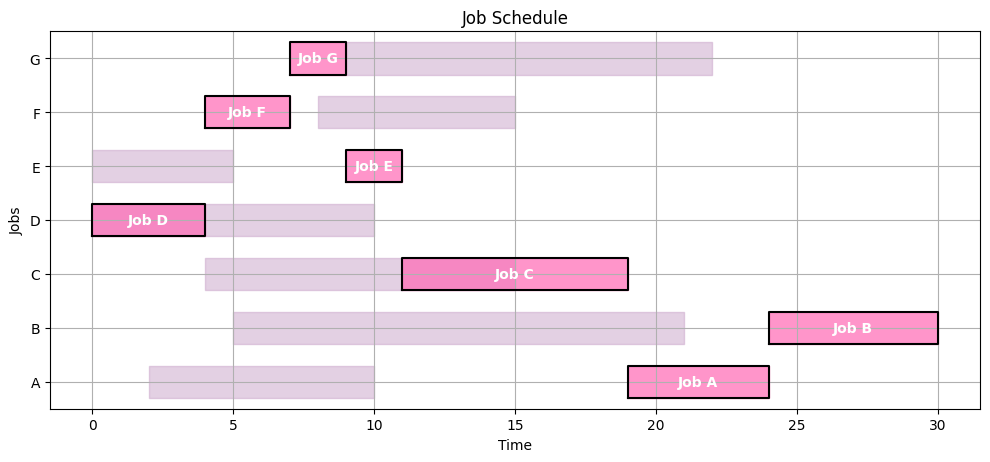

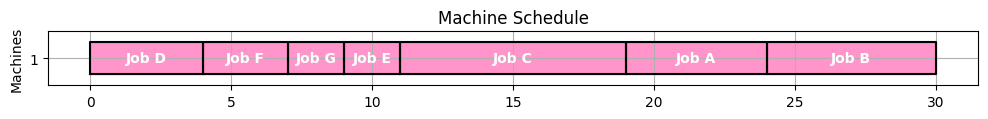

In [ ]:
def opt_schedule(JOBS):

    # Create the mip solver with the SCIP backend.
    m = pywraplp.Solver.CreateSolver('SCIP')
    big_M = sum(JOBS[job_id]['duration'] for job_id in JOBS.keys())

    # upper bounds on how long it would take to process all jobs
    tmax = max([JOBS[job_id]['release'] for job_id in JOBS.keys()]) + sum([JOBS[job_id]['duration'] for job_id in JOBS.keys()])


    # decision variables
    completion_time = []
    auxilaryVar = []
    for job in range(len(JOBS.keys())):
        suffix = '_%s' % job
        completion_time.append(m.NumVar(0, tmax, 'complete' + suffix))

        auxilaryVar_nested=[]
        for _ in JOBS.keys():
            auxilaryVar_nested.append(m.BoolVar('y' + suffix))
        auxilaryVar.append(auxilaryVar_nested)

    # 3 completion time constraints
    for j,job_id in enumerate(JOBS.keys()):
        m.Add(completion_time[j] >= JOBS[job_id]['duration'])
        for k,job_id_k in enumerate(JOBS.keys()):
            if k !=j:
                # Job j finishes before job k starts
                m.Add(completion_time[j] + JOBS[job_id_k]['duration'] <= completion_time[k] + big_M * (1-auxilaryVar[j][k]))
                # Job k finishes before job j starts
                m.Add(completion_time[k] + JOBS[job_id]['duration'] <= completion_time[j]  + big_M * auxilaryVar[j][k])

    # objective function: WSPT minimization
    m.Minimize(sum(JOBS[job_id]['weight']* completion_time[j] for j,job_id in enumerate(JOBS.keys())))

    status = m.Solve()

    if status == pywraplp.Solver.OPTIMAL:

        SCHEDULE = {}
        for j,job_id in enumerate(JOBS.keys()):
            SCHEDULE[job_id] = {'machine': 1, 'start': completion_time[j].solution_value() - JOBS[job_id]['duration'], 'finish': completion_time[j].solution_value()}
        return SCHEDULE

    else:
        print('The problem does not have an optimal solution.')

SCHEDULE = opt_schedule(JOBS_2)
gantt(JOBS_2, SCHEDULE)
kpi(JOBS_2, SCHEDULE)

## **Dispatching Rules**

### **EDD**

['E', 'A', 'D', 'C', 'F', 'B', 'G']


{'Makespan': 30,
 'Max Pastdue': 8,
 'Sum of Pastdue': 27,
 'Number Pastdue': 5,
 'Number on Time': 2,
 'Fraction on Time': 0.2857142857142857,
 'Average Flow Time': 17.0,
 'Weighted Flow Time': 282}

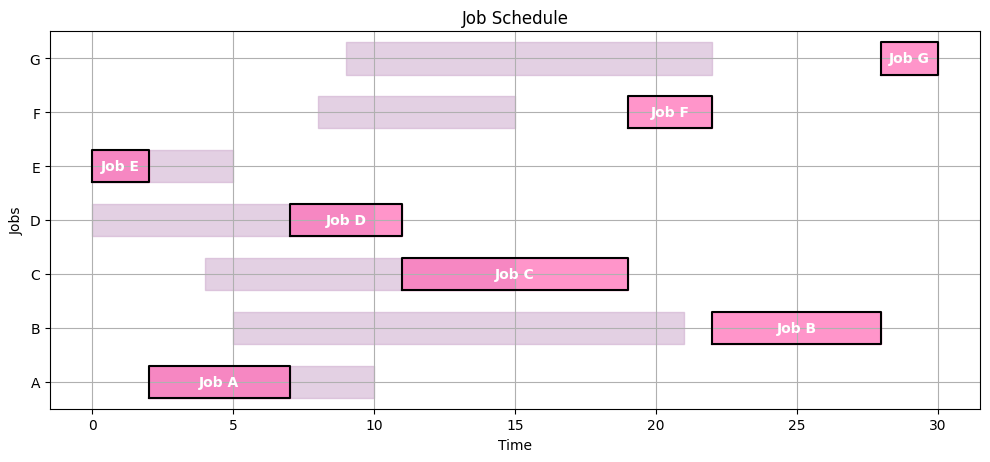

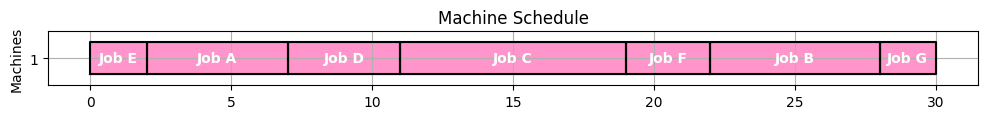

In [ ]:
order=sorted(JOBS_2, key=lambda x: (JOBS_2[x]['due'], x))
print(order)
gantt(JOBS_2, schedule(JOBS_2,order))
kpi(JOBS_2, schedule(JOBS_2,order))

## **Mathematical Models**

#### Max lateness/tardiness

0.0


{'Makespan': 29.99999999999998,
 'Max Pastdue': 7.999999999999979,
 'Sum of Pastdue': 22.999999999999947,
 'Number Pastdue': 4,
 'Number on Time': 3,
 'Fraction on Time': 0.42857142857142855,
 'Average Flow Time': 16.285714285714278,
 'Weighted Flow Time': 277.9999999999999}

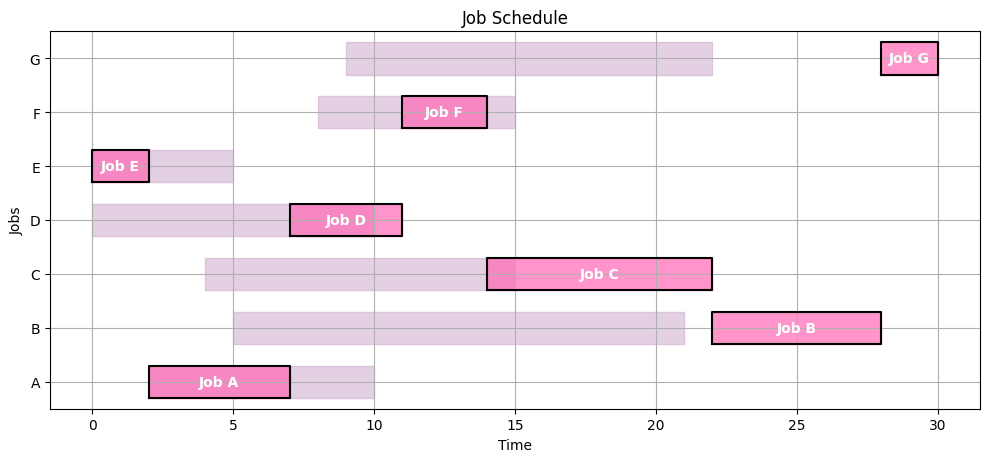

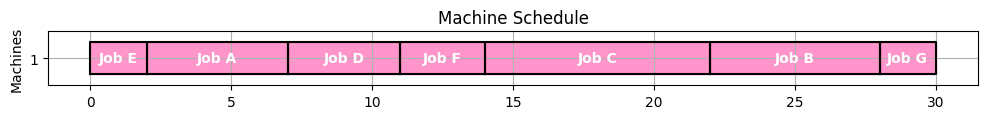

In [ ]:
def opt_schedule(JOBS_2):
    # Create the mip solver with the SCIP backend.
    m = pywraplp.Solver.CreateSolver('SCIP')

    # Calculate the Big M value
    big_M = max(JOBS_2[job_id]['release'] for job_id in JOBS_2.keys()) + sum(JOBS_2[job_id]['duration'] for job_id in JOBS_2.keys())

    # Define the upper bounds on how long it would take to process all jobs
    tmax = max(JOBS_2[job_id]['release'] for job_id in JOBS_2.keys()) + sum(JOBS_2[job_id]['duration'] for job_id in JOBS_2.keys())

    # Decision variables
    completion_time = []
    auxilaryVar = []
    L = []
    for job in range(len(JOBS_2.keys())):
        suffix = '_%s' % job
        completion_time.append(m.NumVar(0, tmax, 'complete' + suffix))
        L = m.NumVar(0, tmax, 'L' + suffix)

        auxilaryVar_nested = []
        for _ in JOBS_2.keys():
            auxilaryVar_nested.append(m.BoolVar('y' + suffix))
        auxilaryVar.append(auxilaryVar_nested)

    # Additional decision variables for use in the objective
    maxpastdue = m.NumVar(-tmax, tmax, 'maxpastdue')

    # Completion time constraints + defining maxpastdue as the maximum lateness
    for j, job_id in enumerate(JOBS_2.keys()):
        m.Add(completion_time[j] >= JOBS_2[job_id]['release'] + JOBS_2[job_id]['duration'])
        for k, job_id_k in enumerate(JOBS_2.keys()):
            if k != j:
                # Job j finishes before job k starts
                m.Add(completion_time[j] + JOBS_2[job_id_k]['duration'] <= completion_time[k] + big_M * (1 - auxilaryVar[j][k]))
                # Job k finishes before job j starts
                m.Add(completion_time[k] + JOBS_2[job_id]['duration'] <= completion_time[j]  + big_M * auxilaryVar[j][k])
        m.Add(L >= (completion_time[j] - JOBS_2[job_id]['due']))

    # Objective function: Minimizing maximum lateness
    m.Minimize(L)

    # Solve the model
    status = m.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print(maxpastdue.solution_value())
        SCHEDULE = {}
        for j, job_id in enumerate(JOBS_2.keys()):
            SCHEDULE[job_id] = {'machine': 1, 'start': completion_time[j].solution_value() - JOBS_2[job_id]['duration'], 'finish': completion_time[j].solution_value()}
        return SCHEDULE
    else:
        print('The problem does not have an optimal solution.')


SCHEDULE = opt_schedule(JOBS_2)
gantt(JOBS_2, SCHEDULE)
kpi(JOBS_2, SCHEDULE)

In [ ]:
JOBS_3 = {
    'A': {'release': 0, 'duration': 5, 'due': 10, 'weight': 2},
    'B': {'release': 0, 'duration': 6, 'due': 21, 'weight': 1},
    'C': {'release': 0, 'duration': 8, 'due': 15, 'weight': 4},
    'D': {'release': 0, 'duration': 4, 'due': 10, 'weight': 8},
    'E': {'release': 0, 'duration': 2, 'due':  5, 'weight': 1},
    'F': {'release': 0, 'duration': 3, 'due': 15, 'weight': 2},
    'G': {'release': 0, 'duration': 2, 'due': 22, 'weight': 1},
}


0.0


{'Makespan': 30.000000000000007,
 'Max Pastdue': 8.000000000000007,
 'Sum of Pastdue': 28.000000000000014,
 'Number Pastdue': 6,
 'Number on Time': 1,
 'Fraction on Time': 0.14285714285714285,
 'Average Flow Time': 17.142857142857146,
 'Weighted Flow Time': 238.0}

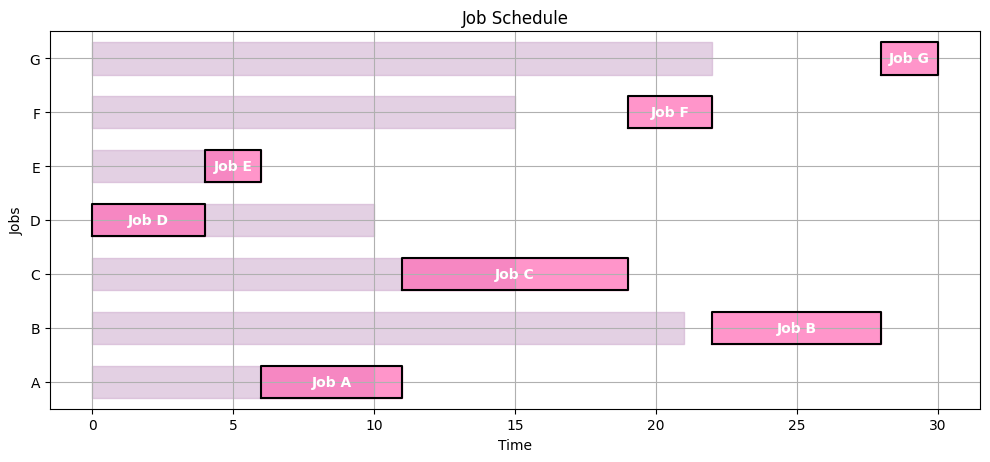

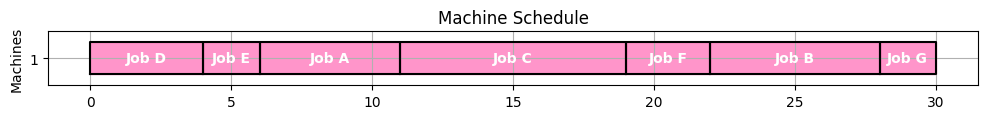

In [ ]:
def opt_schedule(JOBS_3):
    from ortools.linear_solver import pywraplp

    # Create the mip solver with the SCIP backend.
    m = pywraplp.Solver.CreateSolver('SCIP')

    # Calculate the Big M value
    big_M = max(JOBS_3[job_id]['release'] for job_id in JOBS_3.keys()) + sum(JOBS_3[job_id]['duration'] for job_id in JOBS_3.keys())

    # Define the upper bounds on how long it would take to process all jobs
    tmax = max(JOBS_3[job_id]['release'] for job_id in JOBS_3.keys()) + sum(JOBS_3[job_id]['duration'] for job_id in JOBS_3.keys())

    # Decision variables
    completion_time = []
    auxilaryVar = []
    L = []
    for job in range(len(JOBS_3.keys())):
        suffix = '_%s' % job
        completion_time.append(m.NumVar(0, tmax, 'complete' + suffix))
        L = m.NumVar(0, tmax, 'L' + suffix)

        auxilaryVar_nested = []
        for _ in JOBS_3.keys():
            auxilaryVar_nested.append(m.BoolVar('y' + suffix))
        auxilaryVar.append(auxilaryVar_nested)

    # Additional decision variables for use in the objective
    maxpastdue = m.NumVar(-tmax, tmax, 'maxpastdue')

    # Completion time constraints + defining maxpastdue as the maximum lateness
    for j, job_id in enumerate(JOBS_3.keys()):
        m.Add(completion_time[j] >= JOBS_3[job_id]['release'] + JOBS_3[job_id]['duration'])
        for k, job_id_k in enumerate(JOBS_3.keys()):
            if k != j:
                # Job j finishes before job k starts
                m.Add(completion_time[j] + JOBS_3[job_id_k]['duration'] <= completion_time[k] + big_M * (1 - auxilaryVar[j][k]))
                # Job k finishes before job j starts
                m.Add(completion_time[k] + JOBS_3[job_id]['duration'] <= completion_time[j] + big_M * auxilaryVar[j][k])
        m.Add(L >= (completion_time[j] - JOBS_3[job_id]['due']))

    # Objective function: Minimizing maximum lateness
    m.Minimize(L)

    # Solve the model
    status = m.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print(maxpastdue.solution_value())
        SCHEDULE = {}
        for j, job_id in enumerate(JOBS_3.keys()):
            SCHEDULE[job_id] = {'machine': 1, 'start': completion_time[j].solution_value() - JOBS_3[job_id]['duration'], 'finish': completion_time[j].solution_value()}
        return SCHEDULE
    else:
        print('The problem does not have an optimal solution.')

# Example use
SCHEDULE = opt_schedule(JOBS_3)

gantt(JOBS_3, SCHEDULE)
kpi(JOBS_3, SCHEDULE)
